In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import csv
import gzip
import yaml
import os
from general_helpers import annotate_boxplot
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic
from utilities.general_helpers import transpose
from utilities.droplet_dataset import RNAseq_Sample
from shutil import copyfile
import matplotlib.pyplot as plt
import random
from scipy.io import mmread
from droplet_dataset import *


In [2]:
sample_id = 'M138'

Taks SoupX output of selected sample

In [3]:
# file_path = f'/storage/md_keren/shitay/workplace/SoupX/output/{sample_id}_output.csv'
file_path = f'/storage/md_keren/shitay/workplace/SoupX/output/{sample_id}_output_0.3_contamination_frac.csv' # M138_output_0.3_contamination_frac
df = pd.read_csv(file_path, header = 0, index_col=0)
df = df.T

# df = df.T
df.values.shape
barcodes = df.index.tolist()
genes = df.columns.tolist()
counts = df.values
# genes.index('KRT10')
SoupX_output = RNAseq_Sample(counts, genes, barcodes, genes)
print(SoupX_output.number_of_cells)
print(SoupX_output.number_of_genes)

4915
32738


Takes row sample of selected sample
- inject row_sample information of cells into soupX_output to have the information which cells are immune, tumor etc. (the barcodes are at the same order).

In [4]:
ROW_SAMPLES_PATH = fr'/storage/md_keren/shitay/Data/droplet_seq/ROW_DATA'
SAMPLES_INFORMATION_PATH = fr'/storage/md_keren/shitay/Data/inferCNV_data/update_runs/26.6.21'


row_sample = loading_sample(row_data_path=join(ROW_SAMPLES_PATH, f'{sample_id}.pkl'),
                                    cells_information_path=join(SAMPLES_INFORMATION_PATH, f'{sample_id}.pkl'))

SoupX_output.cells_information = row_sample.cells_information
# SoupX_output.barcodes == row_sample.barcodes # check order of barcodes


print(row_sample.number_of_cells)
print(row_sample.number_of_genes)

4915
22020


Takes filtered matrix sample of selected sample_id
- inject row_sample information of cells into filtered_sample to have the information which cells are immune, tumor etc. (the barcodes are at the same order).

In [5]:
SAMPLE_PATH = f'/storage/md_keren/shitay/workplace/SoupX/{sample_id}/filtered_feature_bc_matrix/'

# Extract genes names and features
features_path = join(SAMPLE_PATH, "features.tsv.gz")
feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter="\t")]
gene_names = [row[1] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter="\t")]
mat = np.array(mmread(join(SAMPLE_PATH, "matrix.mtx.gz")).todense()).astype(np.uint16).T
barcodes_path = join(SAMPLE_PATH, "barcodes.tsv.gz")
barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, 'rt'), delimiter="\t")]


filtered_sample = RNAseq_Sample(mat, gene_names, barcodes, feature_ids)
# SoupX_output.barcodes == filtered_sample.barcodes # check order of barcodes
filtered_sample.cells_information = row_sample.cells_information

# make SoupX output to be in the same form as row_output
if you do unique on the gene indexes in the matrix file (the first column, only in Matlab you see it), you get a lower number of genes.
My unerstanding is that they try to map the data to a constant list of genes that contains 32738 genes, but obviously not all of them are expressed in each sample, so not all the indexes appear there.

the output of SoupX is with the name of the genes and not the gene ids, and the name of part of the genes changed a bit. so we can use the names and the features of the filtered data which are at the same lengeth to map SoupX output back to have the reduced gene list as in the row data.

In [346]:
# get the original names and features (gene_ids) from row_sample data
SoupX_output.gene_names = row_sample.gene_names
SoupX_output.features = row_sample.features
SoupX_output.number_of_genes = row_sample.number_of_genes
SoupX_output.cells_information = row_sample.cells_information


gene_indices = [filtered_sample.features.index(g_id) for g_id in row_sample.features]
SoupX_output.counts = SoupX_output.counts[:, gene_indices]

##### Now we can compare expression when the count tables are aligned

In [347]:
noise = row_sample.counts - SoupX_output.counts

noise_sample = RNAseq_Sample(noise, SoupX_output.gene_names, SoupX_output.barcodes, SoupX_output.features)
noise_sample.cells_information = SoupX_output.cells_information

In [348]:
noise.shape

(4915, 22020)

In [349]:
cells_noise = np.mean(noise, axis=1)
genes_noise = np.mean(noise, axis=0)

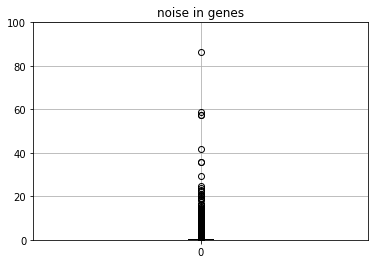

In [350]:
sns.reset_orig()
# annotate_boxplot(pd.DataFrame(cells_noise).boxplot(whis=[5, 95], return_type='dict'), cells_noise)
# pd.DataFrame(cells_noise).boxplot()
fig, ax = plt.subplots()
# bp = pd.DataFrame(genes_noise[(genes_noise!=0) & (genes_noise<100)]).boxplot(ax=ax)
bp = pd.DataFrame(genes_noise).boxplot(ax=ax)
ax.set_title("noise in genes");
ymin, ymax = 0, 100
ax.set_ylim([ymin,ymax])
plt.show()

#### see what is the mean noise in KRT10

In [351]:
KRT_idx = SoupX_output.gene_names.index('KRT10')
genes_noise[KRT_idx]

0.6317362031931265

##### Top noisy genes

In [352]:
# pd.set_option('display.max_rows', None)

n_top_gene = 100
top_genes_indices = np.argsort(genes_noise)[::-1][:n_top_gene]

top_gene_df = pd.DataFrame()
top_gene_df['gene'] = np.array(SoupX_output.gene_names)[top_genes_indices]
top_gene_df['noise'] = genes_noise[top_genes_indices]
top_gene_df

,gene,noise
0,MT-CO2,86.337281
1,FTH1,58.889705
2,MT-CO1,57.535375
3,B2M,57.324796
4,GAPDH,41.540708
...,...,...
95,IFITM3,5.129189
96,RPL24,5.080212
97,RPLP2,5.040680
98,H2AFZ,5.033016


#### Distribution of KRT expression

(0.0, 10.0)

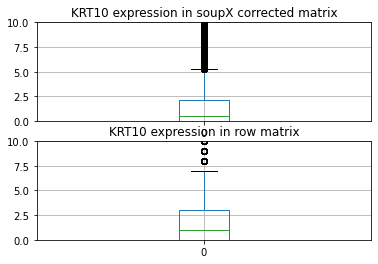

In [353]:
fig, ax = plt.subplots(2)


KRT_idx = SoupX_output.gene_names.index('KRT10')
bx1 = pd.DataFrame(SoupX_output.counts[:, KRT_idx]).boxplot(ax=ax[0])
ax[0].set_title("KRT10 expression in soupX corrected matrix");

KRT_idx = row_sample.gene_names.index('KRT10')
bx2 = pd.DataFrame(row_sample.counts[:, KRT_idx]).boxplot(ax=ax[1])
ax[1].set_title("KRT10 expression in row matrix");



ymin, ymax = 0, 10
ax[0].set_ylim([ymin,ymax])
ax[1].set_ylim([ymin,ymax])

# investigate immune cells' noise VS tumors

Immune:

In [354]:
immune_noise = noise_sample.filter_cells_by_property('is_immune', True)
immune_cells_noise = np.mean(immune_noise.counts, axis=1)
immune_genes_noise = np.mean(immune_noise.counts, axis=0)

immune cells mean noise distribution

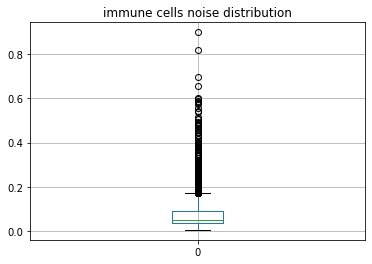

In [355]:
fig, ax = plt.subplots()
# bp = pd.DataFrame(genes_noise[(genes_noise!=0) & (genes_noise<100)]).boxplot(ax=ax)
bp = pd.DataFrame(immune_cells_noise).boxplot(ax=ax)
# ymin, ymax = 0, 100
# ax.set_ylim([ymin,ymax])
ax.set_title("immune cells noise distribution");
plt.show()


immune cells, mean genes noise distribution

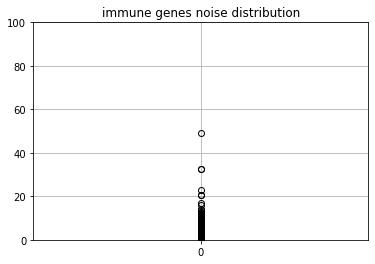

mean noise in KRT10 is 0.355265367054653


,gene,noise
0,MT-CO2,49.096842
1,MT-CO1,32.737383
2,B2M,32.715641
3,GAPDH,22.953189
4,MTRNR2L12,20.595673
...,...,...
95,H2AFZ,2.732150
96,MT-ATP8,2.730198
97,MT-ND5,2.720434
98,RPS6,2.653614


In [356]:
n_top_gene = 100

fig, ax = plt.subplots()
# bp = pd.DataFrame(genes_noise[(genes_noise!=0) & (genes_noise<100)]).boxplot(ax=ax)
bp = pd.DataFrame(immune_genes_noise).boxplot(ax=ax)
ymin, ymax = 0, 100
ax.set_ylim([ymin,ymax])
ax.set_title("immune genes noise distribution");
plt.show()
KRT_idx = immune_noise.gene_names.index('KRT10')
print(f'mean noise in KRT10 is {immune_genes_noise[KRT_idx]}')



top_genes_indices = np.argsort(immune_genes_noise)[::-1][:n_top_gene]
top_gene_df = pd.DataFrame()
top_gene_df['gene'] = np.array(immune_noise.gene_names)[top_genes_indices]
top_gene_df['noise'] = immune_genes_noise[top_genes_indices]
top_gene_df

KRT10 in immune cells

Number of immune cells expressing KRT10 in row data: 1185
Number of immune cells expressing KRT10 in corrected SoupX output: 801
Number of immune cells with some degree of noise 1185
Number of immune cells in sample 2414
[1 1 0 ... 0 8 1]
[0.66543224 0.14107259 0.         ... 0.         5.47286638 0.50882412]
[0.33456776 0.85892741 0.         ... 0.         2.52713362 0.49117588]


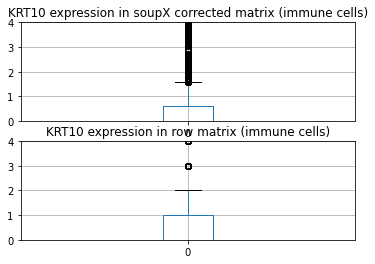

In [367]:
immune_soupX = SoupX_output.filter_cells_by_property('is_immune', True)
immune_row = row_sample.filter_cells_by_property('is_immune', True)

fig, ax = plt.subplots(2)


KRT_idx = immune_soupX.gene_names.index('KRT10')
bx1 = pd.DataFrame(immune_soupX.counts[:, KRT_idx]).boxplot(ax=ax[0])
ax[0].set_title("KRT10 expression in soupX corrected matrix (immune cells)");

KRT_idx = immune_row.gene_names.index('KRT10')
bx2 = pd.DataFrame(immune_row.counts[:, KRT_idx]).boxplot(ax=ax[1])
ax[1].set_title("KRT10 expression in row matrix (immune cells)");



ymin, ymax = 0, 4
ax[0].set_ylim([ymin,ymax])
ax[1].set_ylim([ymin,ymax])


print(f'Number of immune cells expressing KRT10 in row data: {sum(immune_row.counts[:, KRT_idx]>0.5)}')
print(f'Number of immune cells expressing KRT10 in corrected SoupX output: {sum(immune_soupX.counts[:, KRT_idx]>0.5)}')
print(f'Number of immune cells with some degree of noise {sum(immune_noise.counts[:, KRT_idx]>0)}')
print(f'Number of immune cells in sample {immune_soupX.number_of_cells}')


print(immune_row.counts[:, KRT_idx])
print(immune_soupX.counts[:, KRT_idx])
print(immune_noise.counts[:, KRT_idx])

See what part of KRT10 expression on average was removed:

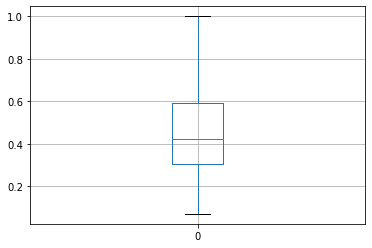

In [359]:
indices = immune_row.counts[:, KRT_idx]!=0
out = np.divide(immune_noise.counts[indices, KRT_idx], immune_row.counts[indices, KRT_idx])
bp = pd.DataFrame(out).boxplot()

tumor:

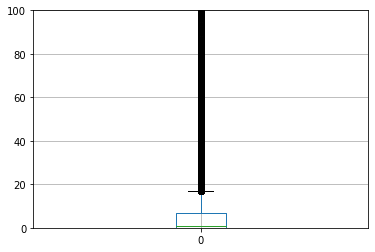

Noise in KRT10 is 79.14591380501608


,gene,noise
0,MT-CO2,30047.679418
1,FTH1,24818.650329
2,B2M,19950.559828
3,MT-CO1,20023.846851
4,GAPDH,14653.740243
5,MTRNR2L12,12519.255699
6,RPLP1,12447.800852
7,RPL41,10263.847567
8,TMSB10,8684.512222
9,MT-ATP6,8354.720619


In [247]:
n_top_gene = 10

tumor_noise = noise_sample.filter_cells_by_property('is_cancer', True)
tumor_cells_noise = np.sum(tumor_noise.counts, axis=1)
tumor_genes_noise = np.sum(tumor_noise.counts, axis=0)
fig, ax = plt.subplots()
# bp = pd.DataFrame(genes_noise[(genes_noise!=0) & (genes_noise<100)]).boxplot(ax=ax)
bp = pd.DataFrame(tumor_genes_noise).boxplot(ax=ax)
ymin, ymax = 0, 100
ax.set_ylim([ymin,ymax])
plt.show()
KRT_idx = tumor_noise.gene_names.index('KRT10')
print(f'Noise in KRT10 is {tumor_genes_noise[KRT_idx]}')


top_genes_indices = np.argsort(tumor_genes_noise)[::-1][:n_top_gene]
top_gene_df = pd.DataFrame()
top_gene_df['gene'] = np.array(tumor_noise.gene_names)[top_genes_indices]
top_gene_df['noise'] = tumor_genes_noise[top_genes_indices]
top_gene_df

# Protein coding overlap with high variance genes (4K first genes)

In [6]:
def keep_protein_coding_only():
    df = pandas.read_excel(PROTEIN_CODING_FILE)
    kept_genes_names = [gene[0] for gene in df[df.lincRNA == 'protein_coding'][['MIR1302-11']].values]
    # indices_of_protein_coding = [i for i in range(len(gene_names)) if gene_names[i] in kept_genes_names]
    # cells = cd45_cells[:, indices_of_protein_coding]
    # gene_names = operator.itemgetter(*indices_of_protein_coding)(gene_names)
    # return cells, gene_names
    return kept_genes_names


PROTEIN_CODING_FILE = r'/storage/md_keren/shitay/Data/tables/gene_ens_map.xlsx'
df = pandas.read_excel(PROTEIN_CODING_FILE, header = None, names=['gene_id', 'gene', '1', '2'])

In [396]:
dd = df[df['2'] == 'protein_coding']
dd

,gene_id,gene,1,2
13870,ENSG00000186092.4,OR4F5,protein_coding,protein_coding
13871,ENSG00000237683.5,AL627309.1,protein_coding,protein_coding
13872,ENSG00000235249.1,OR4F29,protein_coding,protein_coding
13873,ENSG00000185097.2,OR4F16,protein_coding,protein_coding
13874,ENSG00000269831.1,AL669831.1,protein_coding,protein_coding
...,...,...,...,...
34641,ENSG00000212907.2,MT-ND4L,protein_coding,protein_coding
34642,ENSG00000198886.2,MT-ND4,protein_coding,protein_coding
34643,ENSG00000198786.2,MT-ND5,protein_coding,protein_coding
34644,ENSG00000198695.2,MT-ND6,protein_coding,protein_coding


In [433]:
g1 = filtered_sample.gene_names
g2 = tumor_cohort.gene_names
g3 = dd['gene'].tolist()

i1 = filtered_sample.features
i2 = tumor_cohort.features
i3 = dd['gene_id'].tolist()


print(f'num genes in filtered {len(g1)}')
print(f'num genes in row      {len(g2)}')
print(f'num genes in df       {len(g3)}')

num genes in filtered 32738
num genes in row      4000
num genes in df       20776


In [434]:
# g_inter1 = intersection_of_lists(g1, g3)
g_inter2 = intersection_of_lists(g2, g3)

# i_inter1 = intersection_of_lists(i1, i3)
i_inter2 = intersection_of_lists(i2, i3)

In [435]:
print(f'num genes in overlap of df with filtered {len(g_inter1)}')
print(f'num genes in overlap of df with row      {len(g_inter2)}')


print(f'num gene_ids in overlap of df with filtered {len(i_inter1)}')
print(f'num gene_ids in overlap of df with row      {len(i_inter2)}')

num genes in overlap of df with filtered 20185
num genes in overlap of df with row      3924
num gene_ids in overlap of df with filtered 0
num gene_ids in overlap of df with row      0


In [415]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
IMMUNE_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/immune_cells_26.6.21_4k_genes.pkl'

immune_cohort = pickle.load(open(IMMUNE_PATH, 'rb'))

In [432]:
TUMOR_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/tumor_cells_4k_genes.pkl'

tumor_cohort = pickle.load(open(TUMOR_PATH, 'rb'))

In [418]:
len(immune_cohort.gene_names)

4000

See general overlap (noty protein coding genes), whether each gene in 10X shown in the table.

In [30]:
Counter(list(dict(Counter(filtered_sample.gene_names)).values()))

Counter({1: 32552, 2: 88, 4: 1, 3: 2})

In [24]:
df

# Counter(list(dict(Counter(filtered_sample.gene_names)).values()))

# [df[gene].tolist() filtered_sample.gene_names
indices = [df['gene'].tolist().index(g) for g in filtered_sample.gene_names]

ValueError: 'LINC01134' is not in list

In [29]:
sum([(not g in df['gene'].tolist()) for g in filtered_sample.gene_names])

192

# Debug

In [79]:
gene_indices = [SoupX_output.features.index(g_id) for g_id in row_sample.features]

ValueError: 'ENSG00000238009' is not in list

In [ ]:
[row_sample.features.index(g_id) for g_id in SoupX_output.features]

In [93]:
in_l = []
out_l = []
for (gene, gene_idx) in zip(filtered_sample.gene_names, filtered_sample.features):
    if gene_idx in SoupX_output.features:
        in_l.append([gene, gene_idx])
    else:
        out_l.append([gene, gene_idx])

In [144]:
# len(SoupX_output.features)
# len(filtered_sample.features)
# diff_indices = [i for i in range(len(filtered_sample.features)) if filtered_sample.gene_names[i] != SoupX_output.features[i]]
# np.array([filtered_sample.gene_names, SoupX_output.features]).T[diff_indices]

In [95]:
print(len(out_l))
print(len(in_l))

32738
0


In [98]:
filtered_sample.features[:10]

['ENSG00000243485',
 'ENSG00000237613',
 'ENSG00000186092',
 'ENSG00000238009',
 'ENSG00000239945',
 'ENSG00000237683',
 'ENSG00000239906',
 'ENSG00000241599',
 'ENSG00000228463',
 'ENSG00000237094']

In [104]:
SoupX_output.features[:10]

['MIR1302-10',
 'FAM138A',
 'OR4F5',
 'RP11-34P13.7',
 'RP11-34P13.8',
 'AL627309.1',
 'RP11-34P13.14',
 'RP11-34P13.9',
 'AP006222.2',
 'RP4-669L17.10']

In [39]:
noise = filtered_sample.counts - SoupX_output.counts

In [57]:
noise_pr = (np.round(noise*1000).astype(int)).flatten()

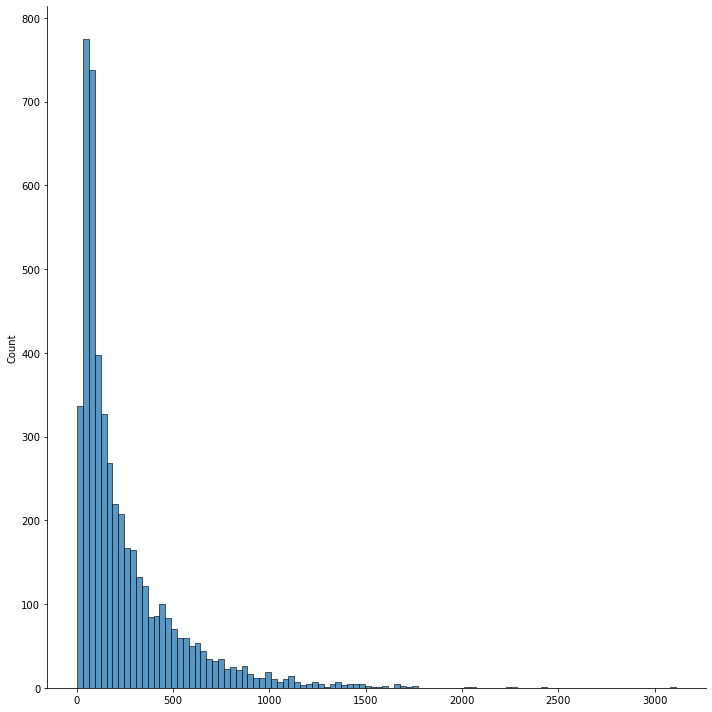

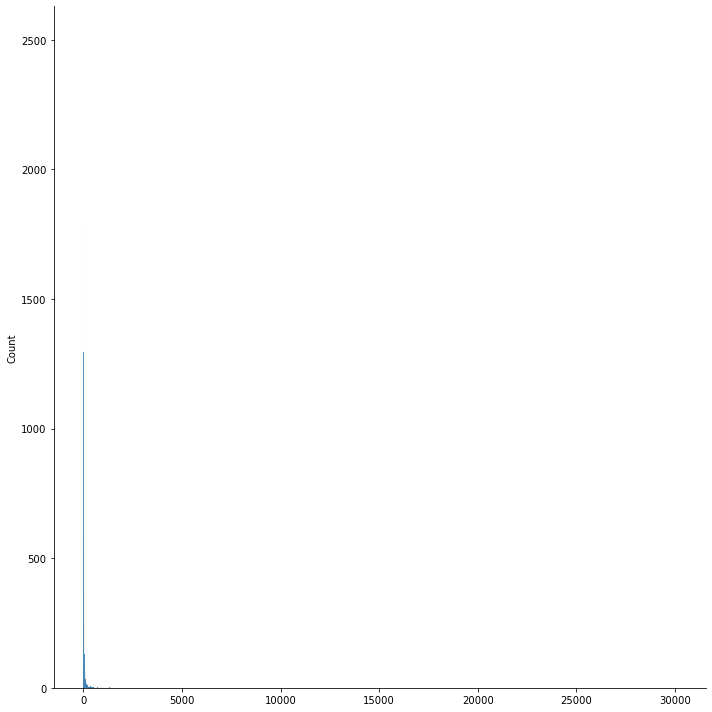

In [89]:
# facetgrid_obj = sns.displot(noise_pr[noise_pr!=0]);
cells_noise = np.sum(noise, axis=1)
genes_noise = np.sum(noise, axis=0)

sns.reset_orig()
facetgrid_obj = sns.displot(cells_noise, height=10);
facetgrid_obj = sns.displot(genes_noise[genes_noise!=0], height=10);

In [115]:
# np.array(gene_names)[genes_noise>200]
KRT_idx = filtered_sample.gene_names.index('KRT10')

print(f'Total read counts {sum(filtered_sample.counts[:,KRT_idx])}')
print(f'noise that was cleaned {genes_noise[KRT_idx]}')

Total read counts 12003
noise that was cleaned 219.86106891151022


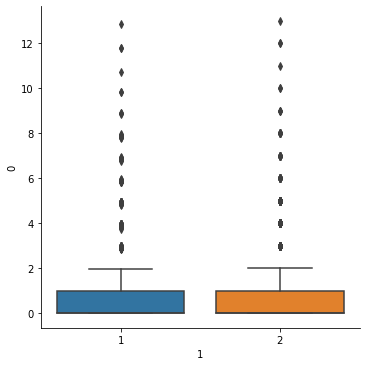

In [237]:
sns.reset_orig()
immune_cells = M138[M138.cells_information.getattr('is_immune')]
gene_index = immune_cells.gene_names.index('KRT10')
values1 = immune_cells.counts[:, gene_index]


immune_cells = rna_sample[rna_sample.cells_information.getattr('is_immune')]
gene_index = immune_cells.gene_names.index('KRT10')
values2 = immune_cells.counts[:, gene_index]


df = pd.DataFrame(np.concatenate([np.array([[v,1] for v in values1]),np.array([[v,2] for v in values2])]))
df[1] = df[1].astype(int)

df# facetgrid_obj = sns.displot(values);
# facetgrid_obj = sns.displot(values);
g = sns.catplot(x=1, y=0, data=df, kind="box");

In [198]:
# sns.catplot(values)
values

array([1, 1, 0, ..., 0, 8, 1], dtype=uint16)

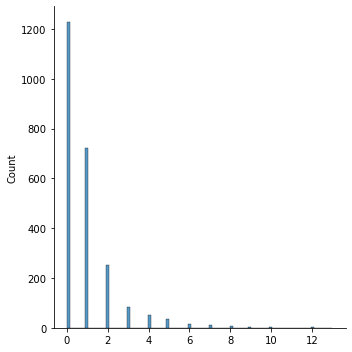

In [196]:
sns.reset_orig()

facetgrid_obj = sns.displot(values);

In [93]:
Counter(df.GENE.value_counts().values)
# df[df.GENE=='PNRC2']

Counter({1: 32738})

In [76]:
Counter(dict(Counter(rna_sample.gene_names)).values())

Counter({1: 21970, 2: 23, 4: 1})

In [94]:
gene_counter = dict(Counter(rna_sample.gene_names))
# [k for k, v in gene_counter.items() if v>1]

check the num of genes in filtered_matrix files
1. tures.tsv.gz:

In [117]:
SAMPLE_PATH = '/storage/md_keren/shitay/workplace/SoupX/MR47/filtered_feature_bc_matrix/'

# Extract genes names and features
features_path = join(SAMPLE_PATH, "features.tsv.gz")
feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter="\t")]
gene_names = [row[1] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter="\t")]
print(Counter(dict(Counter(gene_names)).values()))
print(len(gene_names))

Counter({1: 32552, 2: 88, 3: 2, 4: 1})
32738


In [108]:
SAMPLE_PATH = '/storage/md_keren/shitay/workplace/SoupX/M136/raw_feature_bc_matrix/'

# Extract genes names and features
features_path = join(SAMPLE_PATH, "features.tsv.gz")
feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter="\t")]
gene_names = [row[1] for row in csv.reader(gzip.open(features_path, 'rt'), delimiter="\t")]
print(Counter(dict(Counter(gene_names)).values()))
print(len(gene_names))

Counter({1: 32552, 2: 88, 3: 2, 4: 1})
32738


check the num of genes in filtered_matrix files: matrix.mtx.gz

In [100]:
from scipy.io import mmread

SAMPLE_PATH = '/storage/md_keren/shitay/workplace/SoupX/M138/filtered_feature_bc_matrix/'

mat = np.array(mmread(join(SAMPLE_PATH, "matrix.mtx.gz")).todense()).astype(np.uint16).T

In [102]:
mat.shape

(4915, 32738)

check the num of genes in ROW_DATA files

In [115]:
from droplet_dataset import *

sample_id = 'M138'
ROW_SAMPLES_PATH = fr'/storage/md_keren/shitay/Data/droplet_seq/ROW_DATA'
SAMPLES_INFORMATION_PATH = fr'/storage/md_keren/shitay/Data/inferCNV_data/update_runs/26.6.21'


rna_sample = loading_sample(row_data_path=join(ROW_SAMPLES_PATH, f'{sample_id}.pkl'),
                                    cells_information_path=join(SAMPLES_INFORMATION_PATH, f'{sample_id}.pkl'))
print(rna_sample.number_of_cells)
print(rna_sample.number_of_genes)

4915
22020


Choose a sample with many cells highly expressing KRT10 

In [238]:
cohort_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'
cohort = pickle.load(open(cohort_path, 'rb'))
immune_cells = cohort[cohort.cells_information.getattr('is_immune')]

In [239]:
gene_idx = immune_cells.gene_names.index('KRT10')
sns.reset_orig()
m = immune_cells.counts[:, gene_idx]
cells_with_krt10 = immune_cells[m>1]

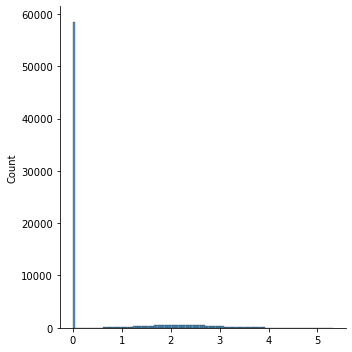

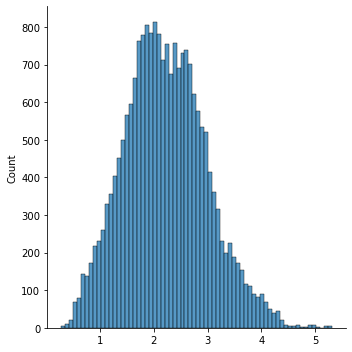

In [244]:
sns.displot(m);
sns.displot(m[m>0]);

In [53]:
total = dict(Counter(immune_cells.samples))
krt = sort_dic(dict(Counter(cells_with_krt10.samples)), by_key=False)
sort_dic({k:round(krt[k]/total[k],3) for k in krt.keys()}, by_key=False)

{'M140': 0.018,
 'M128': 0.077,
 'M135': 0.096,
 'M120': 0.111,
 'M108': 0.13,
 'M145': 0.137,
 'M144': 0.138,
 'M98': 0.147,
 'M139': 0.148,
 'M123': 0.154,
 'M105': 0.175,
 'M115': 0.177,
 'M100': 0.185,
 'M118': 0.195,
 'M133': 0.209,
 'M97': 0.21,
 'M146': 0.212,
 'M114': 0.214,
 'M143': 0.215,
 'M127': 0.217,
 'M129': 0.22,
 'M136': 0.225,
 'M109': 0.234,
 'M132': 0.234,
 'M124': 0.239,
 'M101': 0.252,
 'M141': 0.258,
 'M104': 0.258,
 'M121': 0.258,
 'M137': 0.273,
 'M103': 0.281,
 'M107': 0.284,
 'M125': 0.301,
 'M126': 0.304,
 'M122': 0.307,
 'M102': 0.312,
 'M110': 0.326,
 'M99': 0.326,
 'M130': 0.333,
 'M106': 0.336,
 'M112': 0.347,
 'M134': 0.357,
 'M116': 0.361,
 'M131': 0.361,
 'M111': 0.434,
 'M138': 0.468}